Notebook 1: Data Cleaning
=========================
The purpose of this notebook is to
1. Import the data
2. Clean the data
3. Export the data

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pywaffle import Waffle

import roafr_utils

In [2]:
%matplotlib inline
plt.style.use("dark_background");
plt.set_cmap('Dark2');
sns.set_palette('Dark2')

<Figure size 640x480 with 0 Axes>

# Import Dataset

In [3]:
dfd = roafr_utils.read_csv_of_year(range(2019,2022))

# Clean Accident Dataset

In [4]:
accidents = pd.merge(left=dfd['characteristics'], 
                     right=dfd['locations'],
                     how='outer', 
                     left_on='Num_Acc', 
                     right_on='Num_Acc',
                     validate='one_to_one',
                     indicator=True)

# Check
accidents['_merge'].value_counts()

both          163102
left_only          0
right_only         0
Name: _merge, dtype: int64

## Translation of French Variable Names

In [5]:
accidents.rename(columns={'Num_Acc': 'accident_id', 
                        'an': 'year',                   # Characteristics Dataset
                        'mois':'month', 
                        'jour': 'day', 
                        'hrmn':'hhmm',
                        'lum': 'daylight', 
                        'agg': 'built-up_area', 
                        'int':'intersection_category', 
                        'atm': 'weather',
                        'col': 'collision_category', 
                        'com': 'municipality', 
                        'adr':'address', 
                        'gps': 'gps_origin', 
                        'lat': 'latitude',
                        'long': 'longitude', 
                        'dep': 'department',
                        'catr': 'road_admin_category',  # Locations Dataset 
                        'voie': 'lane',
                        'v1': 'road_numerical_id', 
                        'v2': 'road_alphanumerical_id', 
                        'circ': 'traffic_regime', 
                        'nbv': 'n_lanes', 
                        'pr': 'landmark', 
                        'pr1': 'dist_to_landmark',
                        'vosp': 'reserved_lane',
                        'prof': 'slope',
                        'plan': 'plane_layout',
                        'lartpc': 'median_strip_width',
                        'larrout': 'affected_road_width',
                        'surf': 'surface_condition',
                        'infra': 'infrastructure',
                        'situ': 'location',
                        'env1': 'near_school', 
                        'vma': 'max_speed'},
                        inplace=True)

## Time and Date-Related Variables

In [6]:

# Fix inconsistent year format
accidents['year'].replace({5:2005, 6:2006, 7:2007, 8:2008, 9:2009, 10:2010, 11:2011,
                                        12:2012, 13:2013, 14:2014, 15:2015, 16:2016, 
                                        17:2017, 18:2018},
                                        inplace=True)

# Fix inconsistent time format
accidents['hhmm'] = accidents['hhmm'].apply(lambda s: str(s).replace(':',''))

accidents['hour'] = accidents['hhmm'].apply(lambda hhmm: hhmm[:-2])
accidents['hour'] = accidents['hour'].replace('', np.nan) \
                                                               .fillna(method='bfill')
accidents['minute'] = accidents['hhmm'].apply(lambda hhmm: hhmm[-2:])

accidents['date'] = pd.to_datetime({'year':accidents['year'],
                                                 'month':accidents['month'],
                                                 'day':accidents['day'],
                                                 'hour':accidents['hour'],
                                                 'minute':accidents['minute']})

# New variable: weekday, integer from 0 to 6 representing the weekdays from monday to sunday.
accidents['day_of_week'] = accidents['date'].apply(lambda x: x.day_of_week)

# New binary variable: is_weekend, 0 for monday to friday and 1 for saturday and sunday
accidents['is_weekend'] = (accidents['day_of_week'] > 4).astype('int')

# The hhmm variable will be used in its integer representation for plotting in nb 2
accidents['hhmm'] =accidents['hhmm'].astype('int')

## Department Variable

In [7]:
def department_converter(dep):
    '''
    Takes in a department code as int and returns a string
    e.g. 750 will be '75' for Paris and 201 will be '2B'
    '''
    if dep == 201:
        return '2A'
    elif dep == 202:
        return '2B'
    elif dep>970:
        return str(dep)
    else:
        return str(dep).strip('0')

accidents.loc[(np.less(accidents['year'],2019)),'department'] = \
    accidents[(np.less(accidents['year'],2019))]['department'].apply(department_converter)

## GPS-Data

In [8]:
# Replace commas with periods in GPS Data
accidents['latitude'] = accidents['latitude'].apply(lambda x: x.replace(',', '.')).astype('float')
accidents['longitude'] = accidents['longitude'].apply(lambda x: x.replace(',', '.')).astype('float')

# Convert to Web Mercator Projection
accidents = roafr_utils.df_geotransform(df=accidents)

## Other 

In [9]:
accidents['weather'] = accidents['weather'].fillna(
    accidents['weather'].mode()[0])
accidents['weather'].replace({-1, 0}, inplace=True)
accidents['weather'].astype('int')

0         1
1         1
2         1
3         1
4         1
         ..
163097    5
163098    2
163099    2
163100    1
163101    3
Name: weather, Length: 163102, dtype: int32

In [10]:
accidents['collision_category'] = accidents['collision_category'].fillna(
    accidents['collision_category'].mode()[0])

In [11]:
accidents['built-up_area'].replace({1:0, 2:1}, inplace=True)                                

In [12]:
def na_stats(df, years=None):
    """Compute the number and ratio of missing values for the specified years.
    If no years are specified, the stats for all years will be computed.
    """
    if (years is None) & ('year' in df.columns):
        years = range(df['year'].min(), df['year'].max()+1)

    if isinstance(years, int):
        years = [years]

    if years is not None:
        df = df[df['year'].isin(years)]

    na_stats_df = pd.DataFrame(df.isna().sum(), columns=['na_counts'])
    inverse_n_rows = 1/len(df)
    na_stats_df['na_ratio'] = na_stats_df['na_counts'].apply(lambda x: x*inverse_n_rows)
    na_stats_df.rename_axis('variable', inplace=True)
    na_stats_df = na_stats_df[na_stats_df['na_counts'] != 0]
    na_stats_df.sort_values(by='na_counts', ascending=False, inplace=True)
    return na_stats_df

def plot_na_ratio(df=None, na_stats_df=None, years=None):
    """Plot the ratio of missing values for the specified years.
    """
    if (na_stats_df is not None) & (df is not None):
        raise ValueError('Only one argument of df and na_stats can be used.')
    if (na_stats_df is None) & (df is not None):
        na_stats_df = na_stats(df, years=years)

    sns.barplot(data=na_stats_df,
                x='na_ratio',
                y=na_stats_df.index);
    plt.title('Ratio of Missing Values');
    plt.ylabel('Variable Name');
    plt.xlabel('Ratio of Missing Values');
    return na_stats_df

,na_counts,na_ratio
variable,,
median_strip_width,162634,0.997131
road_alphanumerical_id,151081,0.926298
affected_road_width,58468,0.358475
lane,18269,0.112010
road_numerical_id,10746,0.065885
address,1357,0.008320


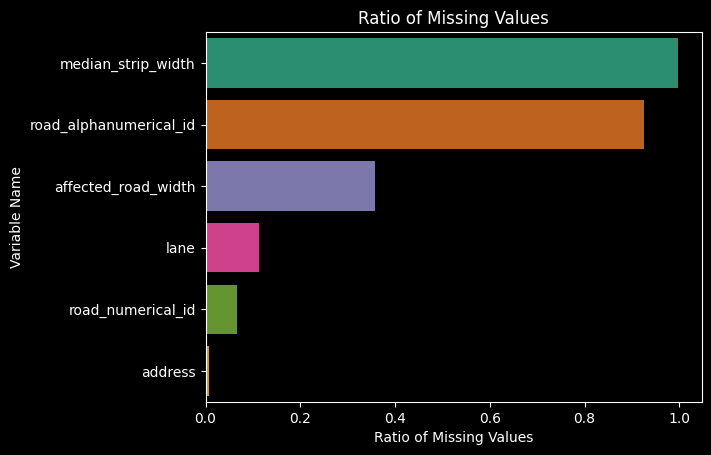

In [13]:
plot_na_ratio(df=accidents, years=range(2019,2022))

# Clean Vehicles Dataset

In [14]:
dfd['vehicles'].rename(columns={
                    'Num_Acc':'accident_id',
                    'id_vehicule':'unique_vehicle_id',
                    'num_veh':'vehicle_id',
                    'senc':'direction',
                    'catv':'vehicle_category',
                    'obs':'immobile_obstacle',
                    'obsm':'mobile_obstacle',
                    'choc':'impact_point',
                    'manv':'last_operation',
                    'motor':'motor_type',
                    'occutc':'n_occupants'}, 
                    inplace=True)

In [15]:
# Missing values are assigned the vale -1 in the original dataset
dfd['vehicles'].replace({-1: np.nan}, inplace=True)
na_stats(dfd['vehicles'])

,na_counts,na_ratio
variable,,
n_occupants,276834,0.991913
direction,1000,0.003583
motor_type,694,0.002487
mobile_obstacle,151,0.000541
impact_point,132,0.000473
last_operation,104,0.000373
immobile_obstacle,96,0.000344
vehicle_category,9,0.000032


In [16]:
# Every single vehicle Id ends with '01', so we can get rid of it
print(dfd['vehicles']['vehicle_id'].apply(lambda x: x[-2:]).value_counts())
dfd['vehicles']['vehicle_id'] = dfd['vehicles']['vehicle_id'].apply(lambda x: x[:-2])

01    279091
Name: vehicle_id, dtype: int64


In [17]:
# Let's see how many values are not alphabetically encoded 8after removing the numeric part)
vehicle_id_az = dfd['vehicles']['vehicle_id'].apply(lambda x: re.search(pattern='[^A-Z]', string=x))
for i_match, this_match in enumerate(vehicle_id_az):
    try:
        vehicle_id_az[i_match] = this_match.group(0)
    except AttributeError:
        pass
vehicle_id_az.value_counts()

[    9
\    1
]    1
Name: vehicle_id, dtype: int64

In [18]:
dfd['vehicles']['vehicle_id'] = dfd['vehicles']['vehicle_id'] \
                                    .replace(dict.fromkeys(['[',']','\\'], np.nan))
dfd['vehicles'].isna().sum()

accident_id               0
unique_vehicle_id         0
vehicle_id               11
direction              1000
vehicle_category          9
immobile_obstacle        96
mobile_obstacle         151
impact_point            132
last_operation          104
motor_type              694
n_occupants          276834
dtype: int64

As a possible improvement the missing values fo vehicle_id could be inferred from the other 
vehicle ids. # This is not done here, because the variable is possibly not necessary because of 
the existence of unique_vehicle_id.

# Clean Persons Dataset

In [19]:
dfd['persons'].rename(columns={
                        'Num_Acc':'accident_id',
                        'id_vehicule':'unique_vehicle_id',
                        'num_veh':'vehicle_id',
                        'place':'seat',
                        'catu':'role',
                        'grav':'severity',
                        'sexe':'sex',
                        'an_nais':'year_of_birth',
                        'trajet':'objective',
                        'secu1':'safety_1',
                        'secu2':'safety_2',
                        'secu3':'safety_3',
                        'locp':'pedestrian_location',
                        'actp':'pedestrian_action',
                        'etatp':'pedestrian_company'
                        },
                        inplace=True)

In [20]:
# Missing values are assigned the vale -1 in the original dataset
dfd['persons'].replace({-1: np.nan}, inplace=True)
na_stats(dfd['persons'])

,na_counts,na_ratio
variable,,
safety_3,363199,0.988498
pedestrian_company,339004,0.922648
pedestrian_location,165644,0.450824
safety_2,134830,0.366959
objective,4026,0.010957
year_of_birth,3067,0.008347
sex,3062,0.008334
safety_1,2912,0.007925
severity,60,0.000163


In [21]:
dfd['persons'].dtypes

accident_id              int64
unique_vehicle_id       object
vehicle_id              object
seat                   float64
role                     int64
severity               float64
sex                    float64
year_of_birth          float64
objective              float64
safety_1               float64
safety_2               float64
safety_3               float64
pedestrian_location    float64
pedestrian_action       object
pedestrian_company     float64
dtype: object

## Severity
The severity is the most important variable, as it will be the target variable for 
machine learning.

In the original database, the severity is encoded as  
*(OLD ORDER)*  
1 - Unharmed  
2 - Killed  
3 - Hospitalized  
4 - Minor injury  

The "hospitalized" indicator is no longer labelled by the public statistics authority as of 2019
[(source)](https://www.data.gouv.fr/en/datasets/bases-de-donnees-annuelles-des-accidents-corporels-de-la-circulation-routiere-annees-de-2005-a-2021/#description). # pylint: disable=C0301
Therefore, the 'injured' categories will be merged.  

For the machine learning classifier provided by the XGBoost package, the classes have to start 
from 0.

The severity categories will also be reordered to make the order more logical:
*(NEW ORDER)*  
0 - Unharmed  
1 - Injured  
2 - Killed  

In [22]:
dfd['persons']['severity'].replace({1:0, 3:1, 4:1}, inplace=True)
dfd['persons']['severity'].fillna(0, inplace=True)
dfd['persons']['severity'] = dfd['persons']['severity'].astype('int')

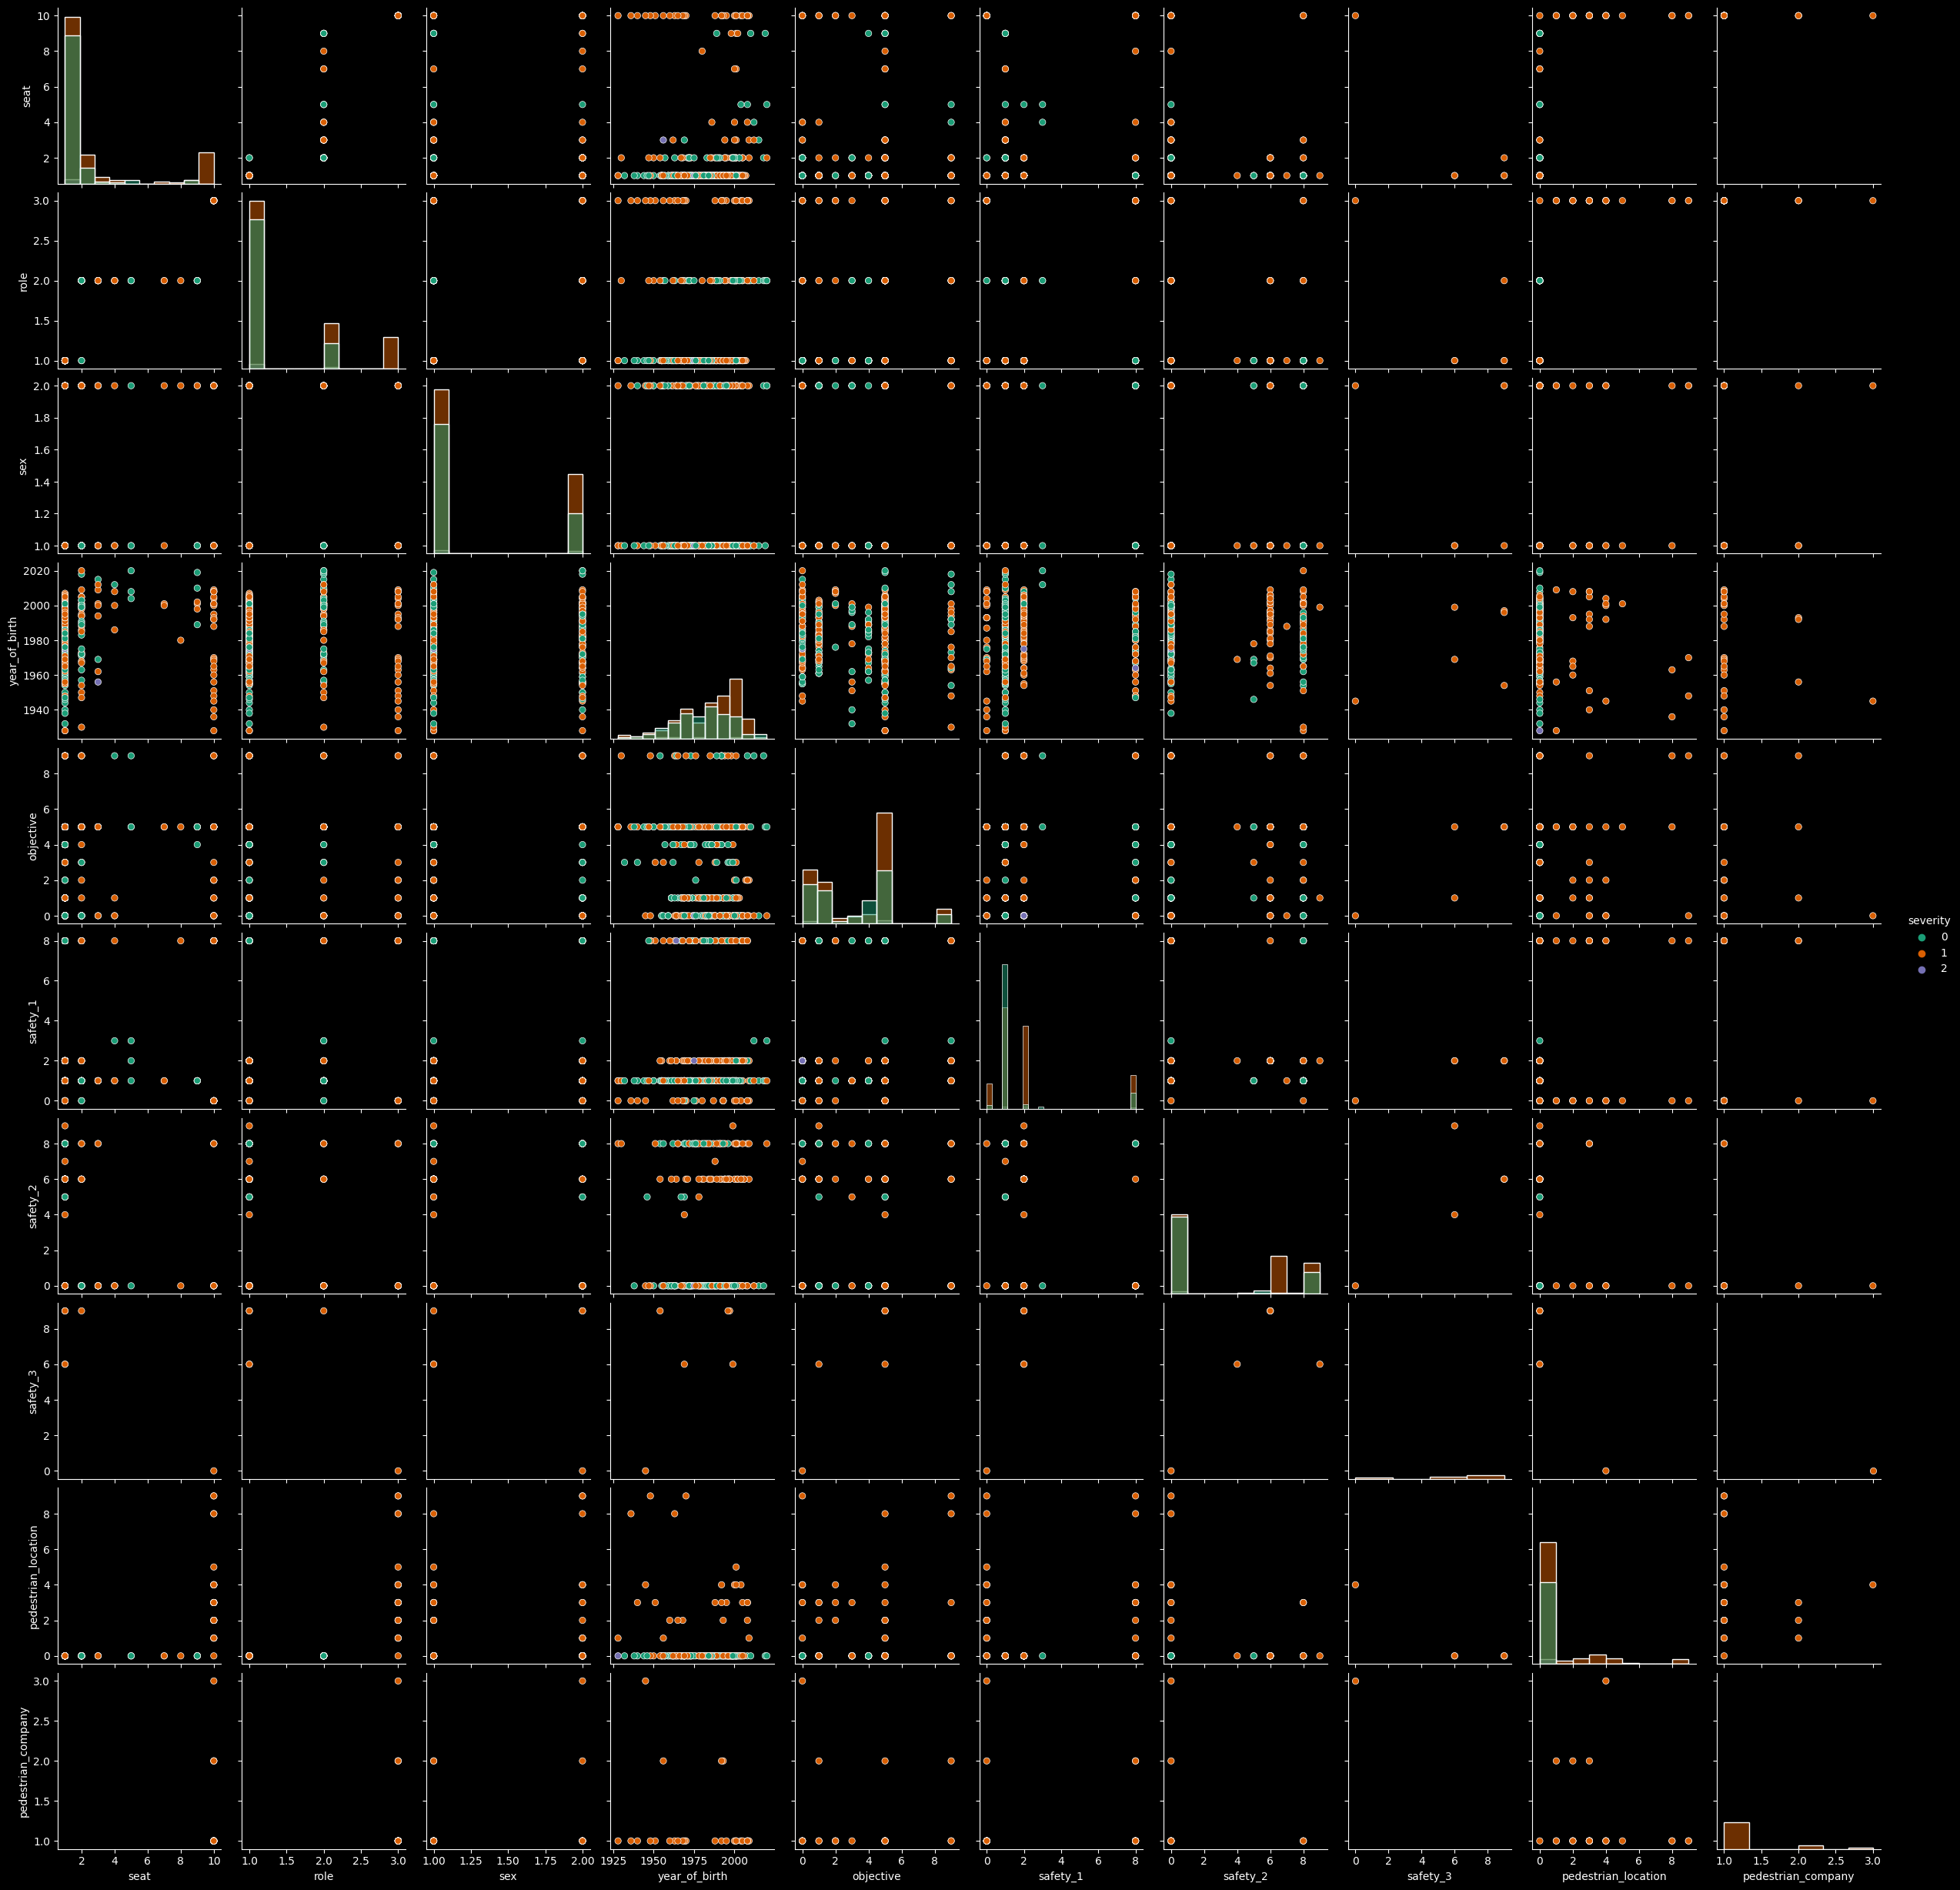

In [23]:
persons_sample = dfd['persons'].sample(frac=0.001, random_state=0)
persons_features = persons_sample.select_dtypes(include=np.number).drop(
    columns=['severity', 'accident_id']).columns
sns.pairplot(data=persons_sample, 
             vars=persons_features, 
             hue='severity', 
             diag_kind='hist',
             palette='Dark2');

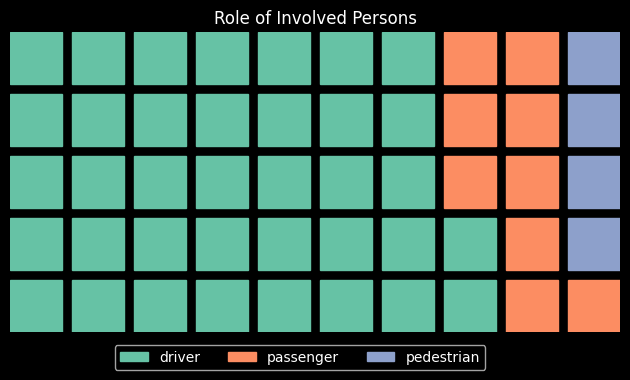

In [24]:
fig = plt.figure(
    FigureClass=Waffle,
    rows=5,
    columns=10,
    values=dfd['persons']['role'].value_counts().sort_index(),
    labels=['driver', 'passenger', 'pedestrian'],
    legend={'loc': 'lower left', 'bbox_to_anchor': (0.16, -0.15), 'ncol':3},
    title={'label':'Role of Involved Persons'})

In [25]:
# The variable pedestrian_company has a high number of missing values.
# This is mostly due to the fact that the number of pedestrians is relatively low
dfd['persons']['pedestrian_company'][dfd['persons']['role']==3].value_counts(dropna=False)

1.0    21640
2.0     5650
3.0     1130
NaN      562
Name: pedestrian_company, dtype: int64

Most of the pedestrians were alone and the missing values are much lower if we only take the 
pedestrians into account. We can therefore assume that the missing values are mostly '1', 
if the person is a passenger. The rest will be set to zero.

In [26]:
dfd['persons'].loc[dfd['persons']['role']==3,'pedestrian_company'] = \
    dfd['persons']['pedestrian_company'][dfd['persons']['role']==3].fillna(1)
dfd['persons'].loc[dfd['persons']['role']!=3,'pedestrian_company'] = \
    dfd['persons']['pedestrian_company'][dfd['persons']['role']!=3].fillna(0)

# Merge Datasets

First, the 'vehicles' and 'persons' dataframes have to be merged on 'unique_vehicle_id'.
Then, this new dataframe will be merged with the 'accidents' dataframe on 'accident_id'

Note:
In the original dataset, pedestrians are associated with a vehicle involved in the accident, 
probably the one that hit them.
I will keep this association for now, but there surely is an alternative way to handle this.

In [28]:
persons_vehicles_merged = pd.merge(left=dfd['vehicles'], 
                        right=dfd['persons'],
                        on='unique_vehicle_id',
                        suffixes=(None, '_y'),
                        validate='one_to_many'
                        )

In [29]:
df_complete = pd.merge(left=accidents,
                right=persons_vehicles_merged,
                on='accident_id',
                suffixes=(None, '_y'),
                validate='one_to_many')

# Feature Engineering

## Age

In [30]:
df_complete.loc[:,'age'] = df_complete['year'] - df_complete['year_of_birth'] 

# Export Data
Two files will be created: A pickle (.p) file containing the whole dataframe and a 
.csv file containing descriptive information about the dataframe.

The .p file has to be ignored because of the file size limit in GitHub. 
The .csv file will be instead to make sure that the data is up-to-date.

In [31]:
roafr_utils.df_to_pickle(df_complete,'df')